<h1>EECS 549 Homework 5</h1>

Haley Johnson

In [1]:
import os
import gzip
import json
import pickle
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from utils import load_person_attributes, get_docid_to_categories, attribute_eval_pipeline, make_df, load_true_relevance
from relevance import *

from ranker import BM25, CrossEncoderScorer, Ranker
from vector_ranker import VectorRanker
from document_preprocessor import RegexTokenizer
from l2r import L2RFeatureExtractor, L2RRanker

<h2>Load Data</h2>

In [2]:
df = pd.read_json("../wikipedia_200k_dataset.jsonl.gz", lines=True)

In [3]:
docs = []
with gzip.open("../wikipedia_200k_dataset.jsonl.gz") as f: 
    doc = f.readline()
    while doc:
        doc = json.loads(doc)
        docid = doc['docid']
        text = doc['text']
        title = doc['title']
        docs.append((docid, title, text))
        doc = f.readline()

In [4]:
document_preprocessor = RegexTokenizer("\\w+", lowercase = True)

In [5]:
encoded_docs = np.load("../wiki-200k-vecs.msmarco-MiniLM-L12-cos-v5.npy")
row_to_docid = [doc[0] for doc in docs]
raw_text_dict = {doc[0]: " ".join(document_preprocessor.tokenize(doc[2])[:500]) for doc in docs}

<h2>Problem 5</h2>

In [6]:
doc_attributes = load_person_attributes("../person-attributes.csv", "../eval/common_attributes.csv")
doc_attributes = pd.DataFrame.from_dict(doc_attributes).T.reset_index()
doc_attributes.columns = ['docid', 'title', 'ethnicity', 'gender', 'religion', 'politics']

In [7]:
common_attributes = pd.read_csv("../eval/common_attributes.csv")
common_attributes = common_attributes[common_attributes['attribute_label'] != 'attribute_label']

In [8]:
attributes = list(np.unique(common_attributes['attribute_label'].values))

<h3>IR System Set Up</h3>

In [9]:
with open("../stopwords.txt") as f:
    words = f.read()
    stopwords = words.split()

network_features = pd.read_csv("network_stats.csv")

with open("../recognized_categories.csv") as f: 
    recognized_categories = f.readlines()

docid_to_categories = get_docid_to_categories("../wikipedia_200k_dataset.jsonl")
docid_to_network_features = network_features.set_index('docid').to_dict(orient = 'index')

feature_names =  ['doc length', 'title length', 'query length', 'doc term frequency', 'doc tf-idf',
                  'title term frequency', 'title tf-idf', 'document BM25', 'document pivoted normalization', 
                  'document pagerank', 'document hub score', 'document authority score', 'uniqueness ratio']
    
all_feature_names = feature_names + recognized_categories
cross_encoder = CrossEncoderScorer(raw_text_dict)

In [10]:
with open("../index", "rb") as f: 
    index = pickle.load(f)

with open("../title_index", "rb") as f: 
    title_index = pickle.load(f)

In [11]:
feature_extractor = L2RFeatureExtractor(index, title_index, docid_to_categories, document_preprocessor, stopwords, 
                                        recognized_categories, docid_to_network_features, cross_encoder)

In [12]:
vector_ranker = VectorRanker('sentence-transformers/msmarco-MiniLM-L12-cos-v5', encoded_docs, row_to_docid)

In [13]:
l2r = L2RRanker(index, title_index, document_preprocessor, stopwords, vector_ranker, feature_extractor)
l2r.train("../hw5_relevance.train.csv")

9604it [00:00, 596082.98it/s]
100%|█████████████████████████████████████████████████| 39/39 [00:02<00:00, 13.41it/s]


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2503
[LightGBM] [Info] Number of data points in the train set: 9604, number of used features: 11


0it [00:00, ?it/s]


<h3>Query 'person'</h3>

100%|███████████████████████████████████████████████| 100/100 [00:04<00:00, 20.10it/s]


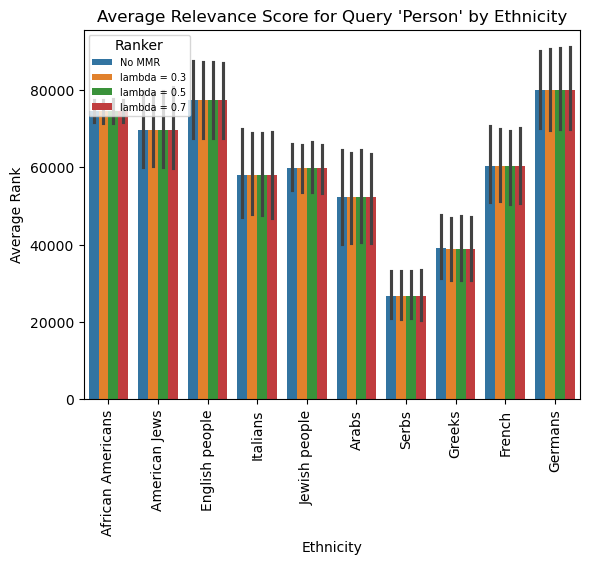

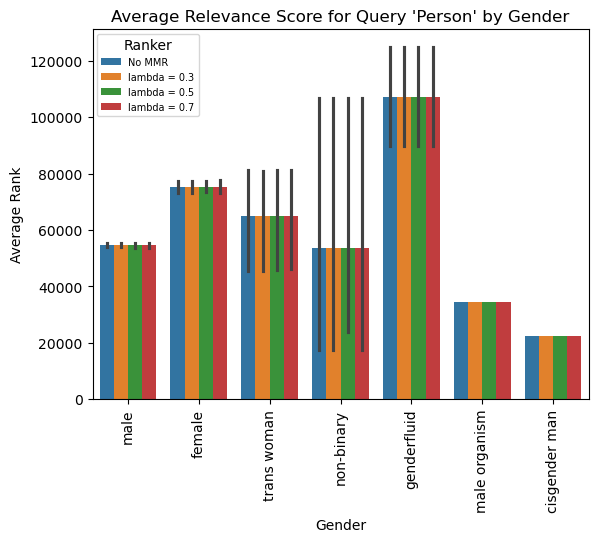

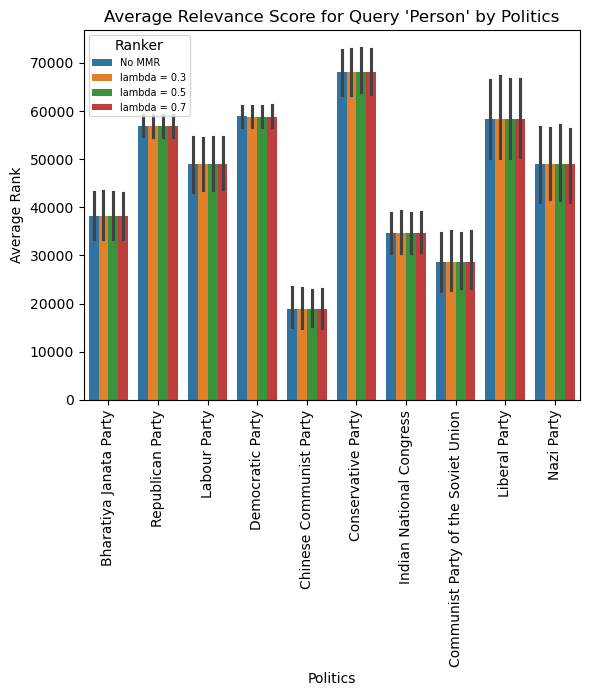

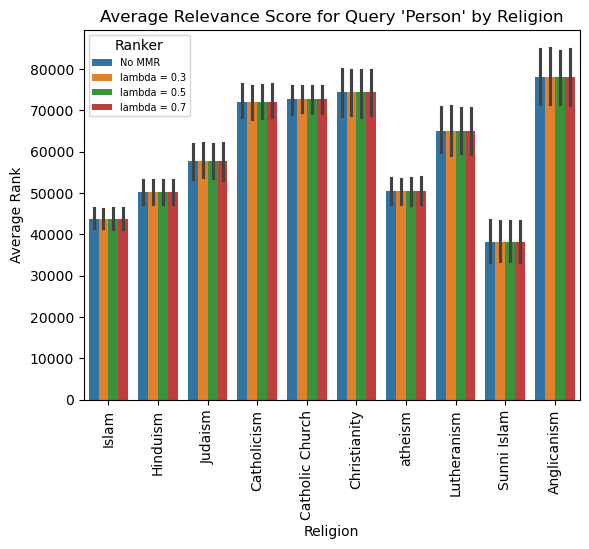

In [14]:
person_df = attribute_eval_pipeline('person', l2r, doc_attributes, attributes, common_attributes)

<h3>Query 'woman'</h3>

100%|███████████████████████████████████████████████| 100/100 [00:05<00:00, 19.06it/s]


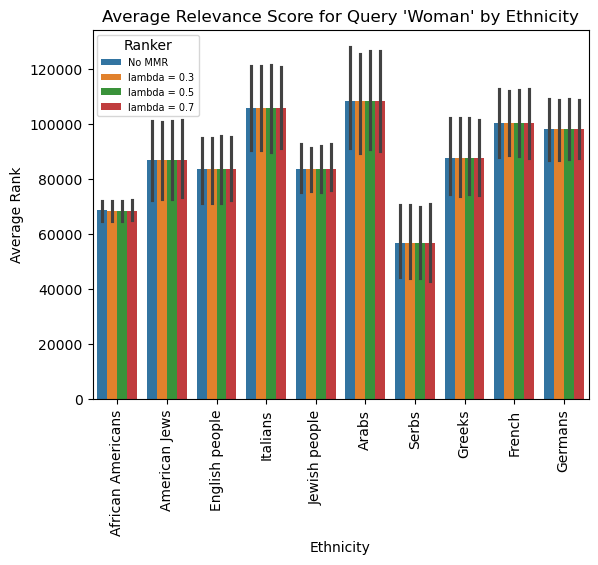

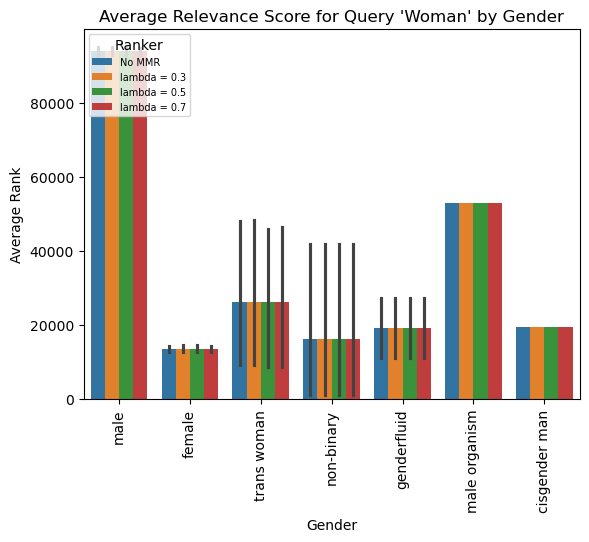

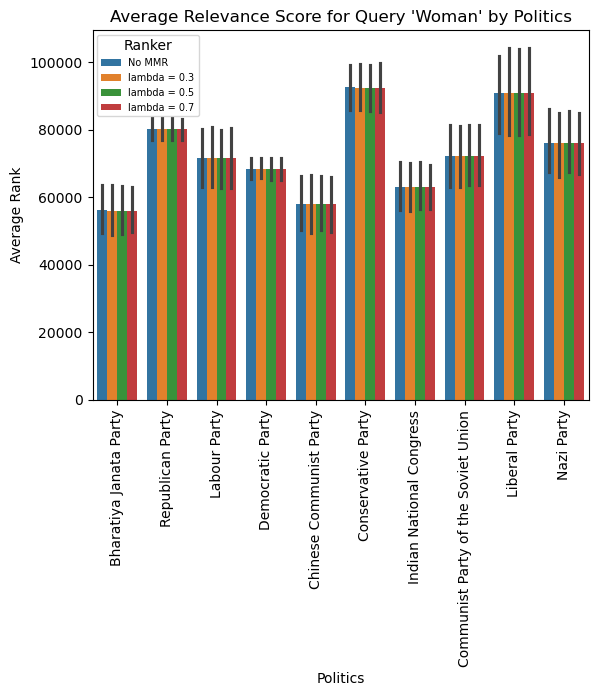

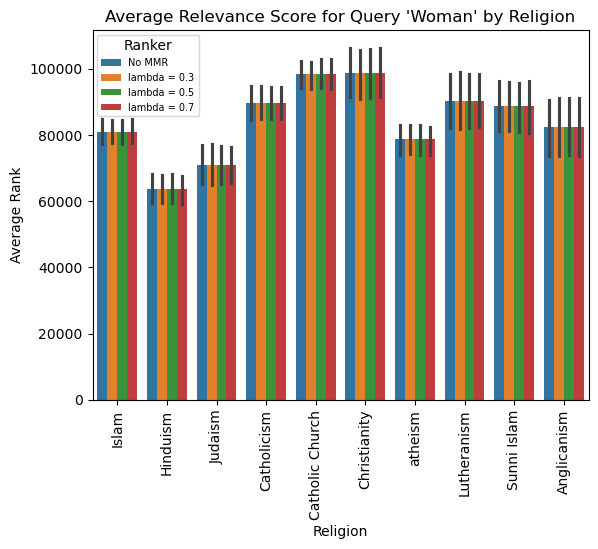

In [15]:
woman_df = attribute_eval_pipeline('woman', l2r, doc_attributes, attributes, common_attributes)

<h3>Query 'teacher'</h3>

100%|███████████████████████████████████████████████| 100/100 [00:05<00:00, 18.14it/s]


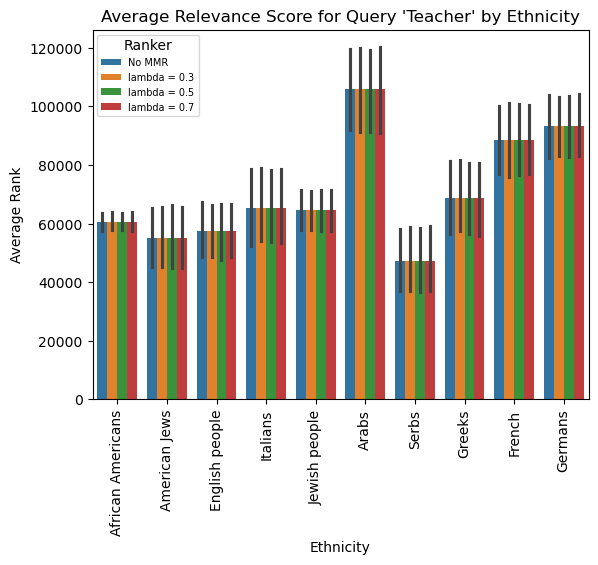

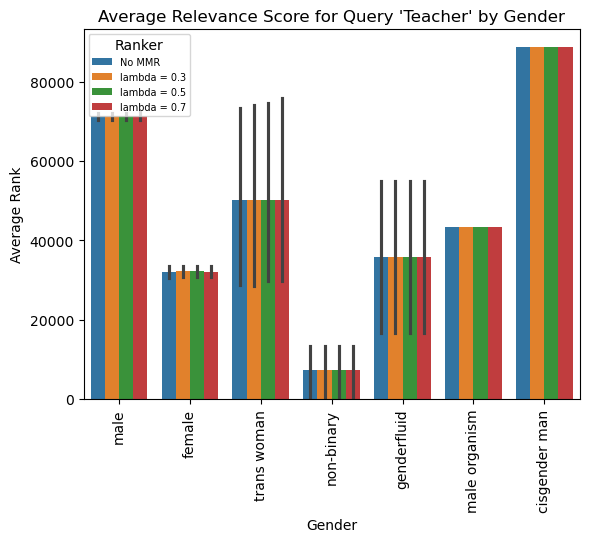

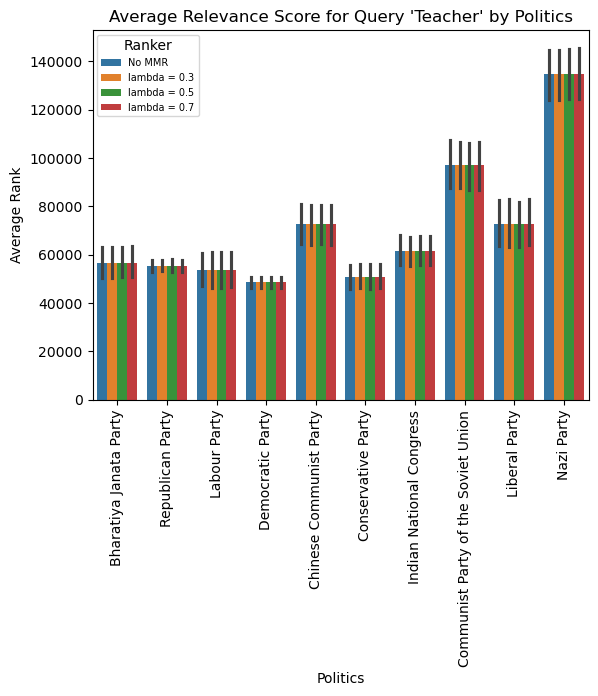

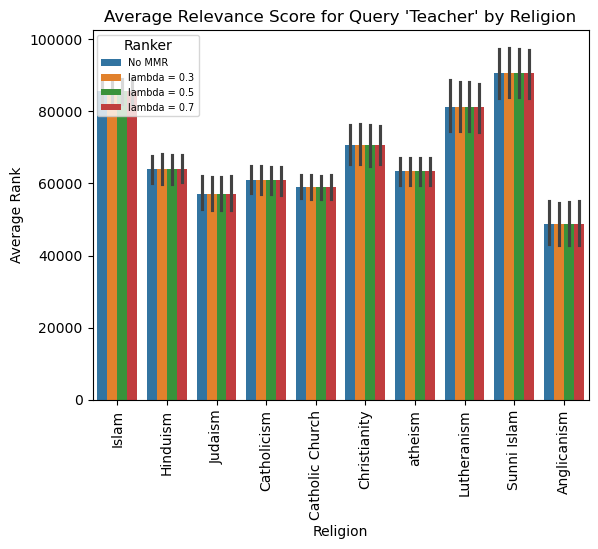

In [16]:
teacher_df = attribute_eval_pipeline('teacher', l2r, doc_attributes, attributes, common_attributes)

<h3>Query 'role model'</h3>

100%|███████████████████████████████████████████████| 100/100 [00:04<00:00, 21.31it/s]


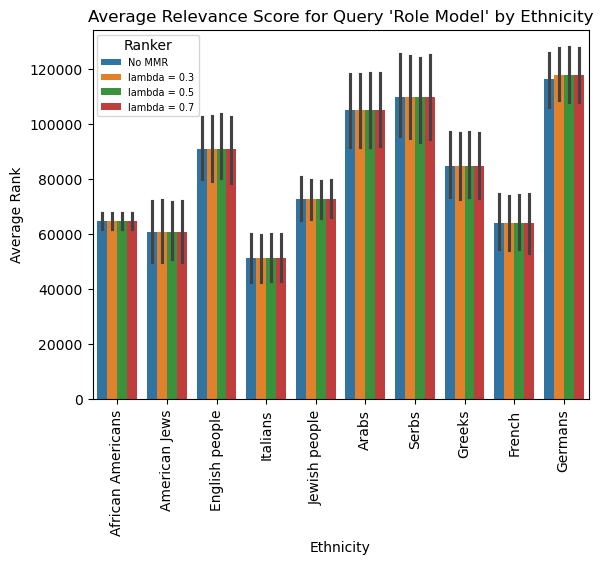

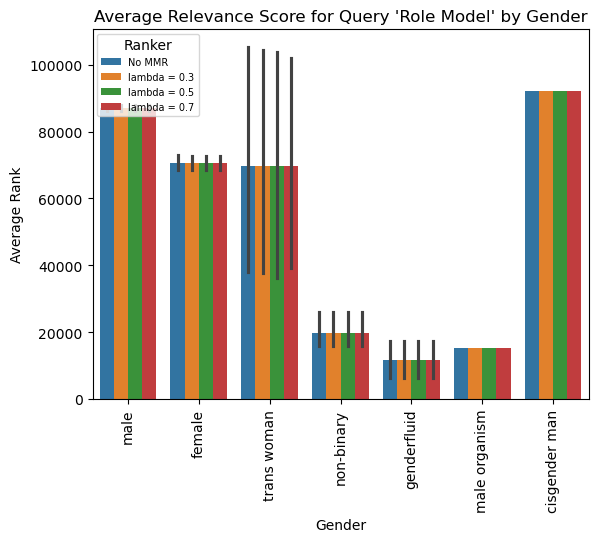

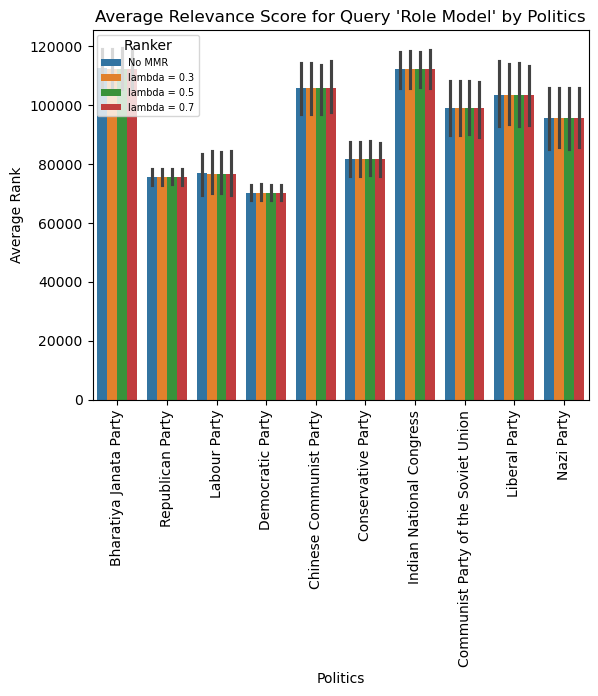

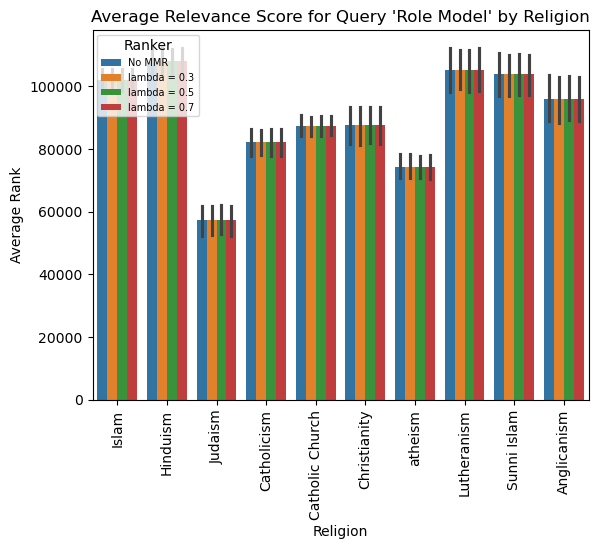

In [17]:
role_model_df = attribute_eval_pipeline('role model', l2r, doc_attributes, attributes, common_attributes)

<h3>Query 'professional'</h3>

100%|███████████████████████████████████████████████| 100/100 [00:04<00:00, 20.95it/s]


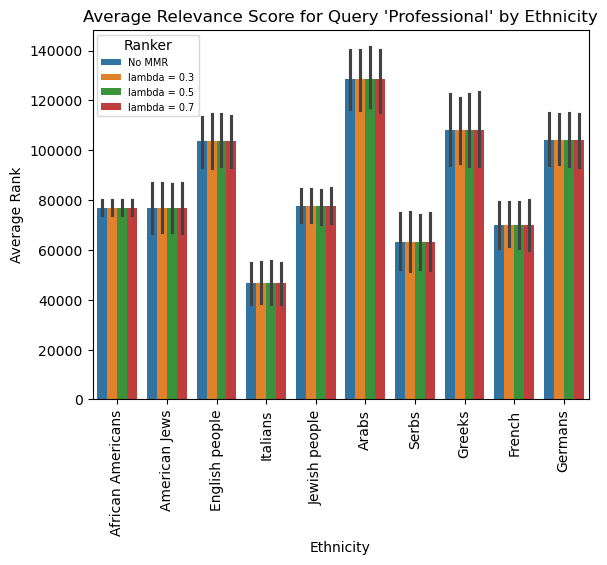

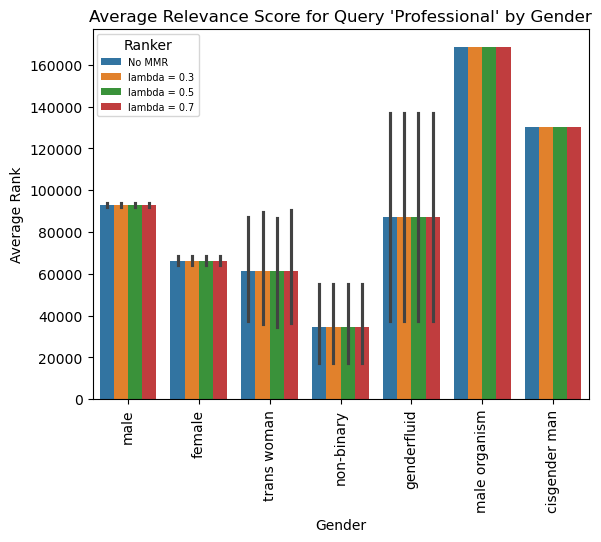

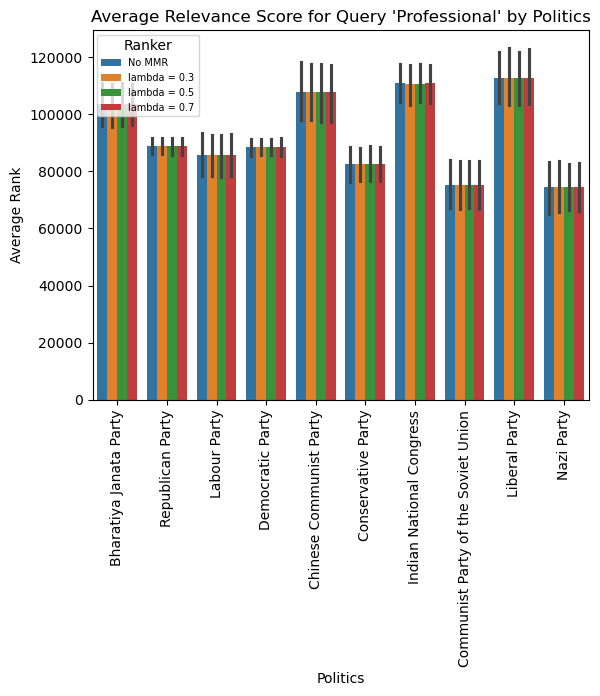

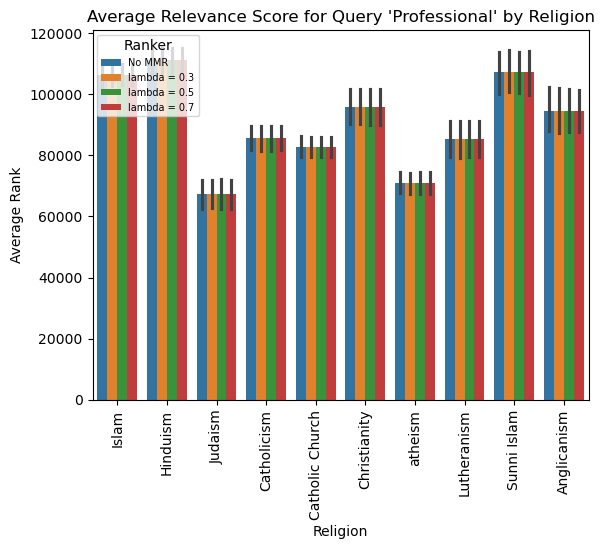

In [18]:
role_model_df = attribute_eval_pipeline('professional', l2r, doc_attributes, attributes, common_attributes)

<h2>Problem 6</h2>

In [19]:
queries_to_judgements = load_true_relevance("../hw5_relevance.test.csv")

In [35]:
os.listdir("../eval/q6")

['.DS_Store', 'hw_2_eval.csv', 'hw_3_eval.csv', 'hw_1_eval.csv']

In [108]:
def run_relevance_tests(queries_to_judgements: dict, outfile:str, ranker, cutoff:int = 10, 
                        pseudofeedback_num_docs = 0, pseudofeedback_alpha = 0.8, pseudofeedback_beta = 0.2, 
                        user_id = None, mmr_lambda:int = 1, mmr_threshold:int = 100) -> dict[str, float]:
    """
    Measures the performance of the IR system using metrics, such as MAP and NDCG.
    
    Args:
        relevance_data_filename [str]: The filename containing the relevance data to be loaded

        ranker: A ranker configured with a particular scoring function to search through the document collection.
                This is probably either a Ranker or a L2RRanker object, but something that has a query() method

    Returns:
        A dictionary containing both MAP and NDCG scores
    """
    maps = []
    ncdgs = []
    for query, relevance_ratings in tqdm(list(queries_to_judgements.items())):

        if type(ranker) == L2RRanker: 
            search_results = ranker.query(query, pseudofeedback_num_docs, pseudofeedback_alpha,
                                          pseudofeedback_beta, user_id, mmr_lambda, mmr_threshold)
        elif type(ranker) == Ranker:
            search_results = ranker.query(query, pseudofeedback_num_docs, pseudofeedback_alpha, pseudofeedback_beta)
        
    
        map_relevance_scores = []
        ndcg_relevance_scores = []
        # add zero for ones 
        if len(search_results) == 0:
            maps.append(0)
            ncdgs.append(0)
            continue
        search_results = sorted(search_results, key = lambda s: s[1], reverse = True)
        for result in search_results[:cutoff]:
            if len(result) == 0:
                continue
            result_docid = int(result[0])
            found = False
            for tup in tqdm(relevance_ratings):
                docid, rel  = tup
                docid = int(docid)
                if int(docid) == int(result_docid):
                    found = True
                    if int(rel) >= 4:
                        map_relevance_scores.append(1)
                        ndcg_relevance_scores.append(1)
                        break
                    else:
                        map_relevance_scores.append(0)
                        ndcg_relevance_scores.append(0)
                        break
            if not found:
                map_relevance_scores.append(0)
                ndcg_relevance_scores.append(0)

        map = map_score(map_relevance_scores, cutoff)
        ncdg = ndcg_score(map_relevance_scores, sorted(ndcg_relevance_scores, reverse = True), cutoff)

        maps.append(map)
        ncdgs.append(ncdg)

        with open(outfile, "a") as e:
            writer = csv.writer(e, delimiter=",")
            r1 = [query, 'map', map]
            r2 = [query, 'ndcg', ncdg]
            writer.writerow(r1)
            writer.writerow(r2)
    return {'map': np.mean(maps), 'ndcg': np.mean(ncdgs)}

<h3>Homework 1 System</h3>

In [36]:
hw_1 = pd.read_csv("../eval/q6/hw_1_eval.csv", header = None)
hw_1.columns = ['query', 'metric', 'score']

<h3>Homework 2 System</h3>

In [56]:
hw_2 = pd.read_csv("../eval/q6/hw_2_eval.csv", header = None)
hw_2.columns = ['query', 'metric', 'score']
#extra row
hw_2 = hw_2[hw_2['query'] != 'query']

<h3>Homework 3 System</h3>

In [57]:
hw_3 = pd.read_csv("../eval/q6/hw_3_eval.csv", header = None)
hw_3.columns = ['query', 'metric', 'score']

<h3>Homework 4 System</h3>

In [71]:
hw_4 = pd.read_csv("../../homework_4/eval/relevance/pseudofeedback_performance_0.9_0.1_10.csv", header = None)
hw_4.columns = ['query', 'metric', 'score']

In [72]:
hw_1.shape, hw_2.shape, hw_3.shape, hw_4.shape

((74, 3), (74, 3), (74, 3), (74, 3))

<h3>Homework 5 System</h3>

In [ ]:
lambda_03 = run_relevance_tests(queries_to_judgements, '../eval/relevance_lambda_03.csv', l2r, 10, mmr_lambda = 0.3, mmr_threshold = 100)

100%|███████████████████████████████████████████████| 100/100 [00:05<00:00, 17.80it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1074151.02it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1398101.33it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1558944.85it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1276527.30it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1455874.12it/s]

 50%|██████████████████████▌                      | 21/42 [00:00<00:00, 727937.06it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1387092.66it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1558944.85it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1761607.68it/s]

100%|███████████████████████████████████████████████| 100/100 [00:06<00:00, 16.51it/s]

100%|███████████████████████████

In [ ]:
lambda_03_df = pd.read_csv('../eval/relevance_lambda_03.csv', header = None)
lambda_03_df.columns = ['query', 'metric', 'score']

In [ ]:
lambda_03_df['score'].max()

In [77]:
lambda_05 = run_relevance_tests(queries_to_judgements, '../eval/relevance_lambda_05.csv', l2r, 10, mmr_lambda = 0.5)

100%|███████████████████████████████████████████████| 100/100 [00:05<00:00, 17.68it/s]

100%|█████████████████████████████████████████████| 42/42 [00:00<00:00, 710325.68it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1314632.60it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1443940.72it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1505647.59it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1455874.12it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1558944.85it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1398101.33it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1661894.04it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1835008.00it/s]

100%|███████████████████████████████████████████████| 100/100 [00:05<00:00, 18.09it/s]

100%|███████████████████████████

In [83]:
lambda_05_df = pd.read_csv('../eval/relevance_lambda_05.csv', header = None)
lambda_05_df.columns = ['query', 'metric', 'score']

In [82]:
lambda_07 = run_relevance_tests(queries_to_judgements, '../eval/relevance_lambda_07.csv', l2r, 10)

100%|███████████████████████████████████████████████| 100/100 [00:05<00:00, 17.57it/s]

100%|█████████████████████████████████████████████| 42/42 [00:00<00:00, 834885.16it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1206580.60it/s]

100%|█████████████████████████████████████████████| 42/42 [00:00<00:00, 240001.05it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1505647.59it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1344738.69it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1355082.83it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 2001826.91it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1398101.33it/s]

100%|████████████████████████████████████████████| 42/42 [00:00<00:00, 1492887.86it/s]

100%|███████████████████████████████████████████████| 100/100 [00:05<00:00, 18.89it/s]

100%|███████████████████████████

In [85]:
lambda_07_df = pd.read_csv("../eval/relevance_lambda_07.csv", header = None)
lambda_07_df.columns = ['query', 'metric', 'score']

In [ ]:
run_relevance_tests(queries_to_judgements, '../eval/test.csv', l2r, 10)

In [105]:
queries_to_judgements["How did the Scramble for Africa affect the continent's history and development"][0]

(54115568, 5)

In [107]:
l2r.query('wikipedia')

100%|███████████████████████████████████████████████| 100/100 [00:04<00:00, 20.54it/s]


[(61328693, 0.04620809853076935),
 (61327875, -0.031551435589790344),
 (61327392, -0.08661606907844543),
 (61324726, 0.12135356664657593),
 (61324701, -0.1498429775238037),
 (61319328, -0.003129679709672928),
 (61319041, -0.02674015611410141),
 (61314575, -0.03003590553998947),
 (61313590, -0.07768882811069489),
 (61313146, 0.06198791414499283),
 (61312534, 0.08226232975721359),
 (61312256, 0.04146772623062134),
 (61310770, 0.014707583002746105),
 (61310619, -0.040404655039310455),
 (61309714, -0.03440220281481743),
 (61309169, 0.14152714610099792),
 (61308340, -0.002581335138529539),
 (61308055, -0.09851554781198502),
 (61306489, 0.03771034628152847),
 (61305195, -0.02068127505481243),
 (61302185, -0.0588199682533741),
 (61299887, -0.004878241568803787),
 (61299740, 0.043377120047807693),
 (61298194, -0.009370079264044762),
 (61298057, -0.04555831849575043),
 (61298030, 0.12505917251110077),
 (61297613, -0.015667356550693512),
 (61296215, 0.0979384109377861),
 (61295734, 0.09950828552